In [2]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
%matplotlib inline
plt.viridis()

In [14]:
no_iterations = 3000000

# Wiring
n = 16
N_layer = n ** 2
S = (n, n)

# Membrane
v_rest = -70 * mvolt #mV
e_ext = 0 * mvolt #V
v_thr = -54 * mvolt #mV
g_max = 0.2
tau_m = 20* ms #ms
tau_ex = 5* ms #ms
e = np.e
g = g_max
pre_t = 0 * ms


# Inputs
f_mean = 20 * Hz
f_base = 5 * Hz
f_peak = 152.8  * Hz
sigma_stim = 2
t_stim = 0.02 * second
rate = 200 * Hz

# STDP
Apre = a_plus = 0.1
b = 1.2
taupre = tau_plus = 20 * ms #ms
taupost = tau_minus = 64 * ms #ms
Apost = a_minus = (a_plus * tau_plus * b) / tau_minus

creating /tmp/scipy-bogdanp-o2pasK/python27_intermediate/compiler_33953ccda0eb3891e0e2ada457906658
0. s 5.2 ms 10.5 ms 15.7 ms 21. ms 26.3 ms 31.5 ms 36.8 ms 42.1 ms 47.3 ms 52.6 ms 57.8 ms 63.1 ms 68.4 ms 73.6 ms 78.9 ms 84.2 ms 89.4 ms 94.7 ms rate =  0. Hz


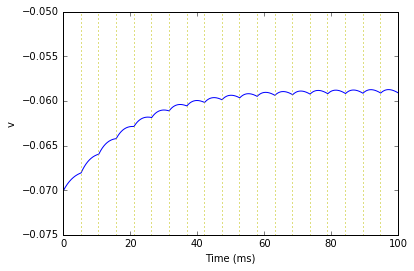

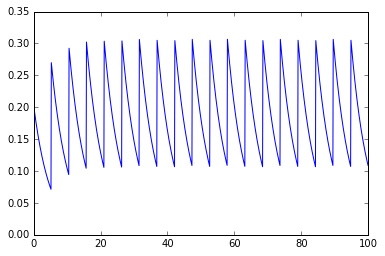

In [15]:
start_scope()
eqs = '''
dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
dgex/dt = -gex/tau_ex: 1
'''
G = NeuronGroup(1, eqs, threshold='v > -54 * mV',
                reset='v = -70 * mV', method='euler', dt=0.1 * ms)#, events={'trigger_stdp' : 'v > v_thr'})
G.v = -70*mV
G.gex = 0.0
# G.run_on_event('trigger_stdp', 'x=0')
# event_mon = EventMonitor(group, 'trigger_stdp')
statemon = StateMonitor(G, ['v', 'gex',], record=0)
spikemon = SpikeMonitor(G)



# Pre pop
# gap = 100 * ms / (rate  * (100 *ms))
times = np.linspace(0, 100, rate  * (100 *ms)) * ms
inp = SpikeGeneratorGroup(1, [0] * len(times), times)

# Connection from pre pop
feedforward = Synapses(inp, G, 
                 '''
                 w : 1
                 dapre/dt = -apre/taupre : 1 (event-driven)
                 dapost/dt = -apost/taupost : 1 (event-driven)
                 ''', 
                 on_pre=
                 '''
                 gex_post += w
                 apre += Apre
                 w = clip(w+apost, 0, g_max)
                 ''',
                 on_post='''
                 apost += Apost
                 w = clip(w+apre, 0, g_max)
                 ''')
feedforward.connect(j='i')
feedforward.w = g_max
# feedforward.g = g_max



# G.g = linked_var(feedforward, 'g')
# print G.g


inp_spikemon = SpikeMonitor(inp)

run(100*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
    print t,
for t in inp_spikemon.t:
    axvline(t/ms, ls=':', c='y', lw=1)
    print t,
xlabel('Time (ms)')
ylabel('v')
ylim([-.075, -.05])
figure()
plot(statemon.t/ms, statemon.gex[0])
print "rate = ", len(spikemon.t) / (100 * ms)

In [201]:
np.linspace(0, 100, rate  * (100 *ms))

array([   0.        ,    7.14285714,   14.28571429,   21.42857143,
         28.57142857,   35.71428571,   42.85714286,   50.        ,
         57.14285714,   64.28571429,   71.42857143,   78.57142857,
         85.71428571,   92.85714286,  100.        ])

In [110]:
print times

[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.] ms


In [154]:
rate  * (100 *ms)

20.0

In [245]:
rate

157.8

In [22]:
generate_rates((13,8))

array([[  57.51660517,   63.97763112,   71.06270622,   78.71902374,
          86.78794628,   94.90915672,  102.36199771,  107.90900686,
         110.0178018 ,  107.90900686,  102.36199771,   94.90915672,
          86.78794628,   78.71902374,   71.06270622,   63.97763112],
       [  54.95366561,   60.77622248,   67.03768716,   73.63065817,
          80.34089605,   86.78794628,   92.3665846 ,   96.26265552,
          97.6778848 ,   96.26265552,   92.3665846 ,   86.78794628,
          80.34089605,   73.63065817,   67.03768716,   60.77622248],
       [  51.98752943,   57.13514129,   62.56119641,   68.13317602,
          73.63065817,   78.71902374,   82.9435055 ,   85.78186017,
          86.78794628,   85.78186017,   82.9435055 ,   78.71902374,
          73.63065817,   68.13317602,   62.56119641,   57.13514129],
       [  48.77793296,   53.2640424 ,   57.90351088,   62.56119641,
          67.03768716,   71.06270622,   74.30800846,   76.4347582 ,
          77.17760926,   76.4347582 ,   74.30

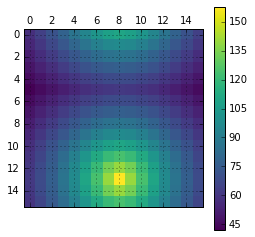

In [23]:

plt.matshow(generate_rates((13,8))/Hz, fignum=100)
plt.grid(visible=True)
plt.colorbar()

In [24]:
def distance(s, t, grid_size=S, dist_type='euclidian'):
    '''
    Function that computes distance in a grid of neurons taking into account periodic boundry conditions.
    
    First, translate source into the center of the grid.
    Second, translate target by the same amount.
    Finally, perform desired distance computation.
    '''
    s = np.asarray(s)
    t = np.asarray(t)
    _grid_size = np.asarray(grid_size)
    trans = s - (_grid_size//2)
    s = np.mod(s - trans, grid_size)
    t = np.mod(t - trans, grid_size)
    if dist_type == 'manhattan':
        return s[0] - t[0] + s[1] - t[1]
    return np.sqrt((s[0] - t[0])**2 + (s[1] - t[1])**2)

In [25]:
def generate_rates(s, grid_size=S, dist_type='euclidian'):
    '''
    Function that generates an array the same shape as the input layer so that 
    each cell has a value corresponding to the firing rate for the neuron
    at that position.
    '''
    _rates = np.zeros(S)
    for x, y in np.ndindex(S):
        _d = distance(s, (x,y), grid_size=grid_size, dist_type=dist_type)
        _rates[x, y] = f_base + f_peak * np.e ** (-_d/(2 * sigma_stim**2))
    return _rates * Hz
        

**Neuron dynamics (target-layer)**: the membrane voltage $V_{mem}$ is described by:

$\tau_{mem}\frac{\delta V_{mem}}{\delta t} = V_{rest} - V_{mem} + g_{ex}(t)(E_{ex}-V_{mem})$


$E_{ex}$ = excitatory reversal potential; $V_{rest}$ = resting potential; $\tau_{mem}$ = membrane time constant. Upon reaching a threshold $V_{thr}$, a spike occurs and $V_{mem}$ is reset to $V_{rest}$. A presynaptic
spike at time 0 causes a synaptic conductance at time $t \geq O$ of $g_{ex}(t) = ge^\frac{-t}{\tau_{ex}}(\tau_{ex}$= synaptic time constant); this is cumulative for all pre-synaptic spikes.

**STDP**: a pre-synaptic spike at time $t_{pre}$ and post-synaptic spike at $t_{post}$ modify the synaptic
conductance by $g —> g + g_{max}F(\Delta t)$,where $\Delta t = t_{pre}—t_{post}$ and $F(\Delta t) = A_{+}exp (\Delta t/T_{+})$ if
$\Delta t$ < 0, otherwise $F(\Delta t) = -A_{-}exp (-\Delta t/T_{-})$, where $A_{+/-}$ are magnitudes and 
$\tau_{+/-}$ are time constants for potentiation and depression respectively. This is cumulative for all pre and
post-synaptic spike pairs; g is bounded in (0, $g_{max}$).

In [28]:
def simulate(input_source=(7,7), N=16**2, duration=100*ms, dt=0.1 * ms, rate=200 * Hz):
    start_scope()
    neuron_dynamics = '''
    dv/dt = (v_rest-v + gex * (e_ext - v))/tau_m : volt
    dgex/dt = -gex/tau_ex: 1
    '''
    G = NeuronGroup(N, neuron_dynamics, threshold='v > -54 * mV',
                    reset='v = -70 * mV', method='euler', dt=0.1 * ms)
    G.v = -70*mV
    G.gex = 0.0
    statemon = StateMonitor(G, ['v', ], record=0)
    spikemon = SpikeMonitor(G)



    # Pre pop
    location = np.random.randint(0,16, 2)
    rates = generate_rates(location)
    inp = PoissonGroup(N, rates.ravel())
    
    synapse_model = '''
                     w : 1
                     dapre/dt = -apre/taupre : 1 (event-driven)
                     dapost/dt = -apost/taupost : 1 (event-driven)
                     '''
    on_pre_model = '''
                     gex_post += w
                     apre += Apre
                     w = clip(w+apost, 0, g_max)
                     '''
    on_post_model = '''
                     apost += Apost
                     w = clip(w+apre, 0, g_max)
                     '''

    # Connection from pre pop
    feedforward = Synapses(inp, G, synapse_model, 
                     on_pre = on_pre_model,
                     on_post = on_post_model,
                     dt = dt)
    feedforward.connect(j='k for k in range(16**2)')
    feedforward.w = g_max
    
    # Lateral connections (from target to target)
    lateral = Synapses(G, G, synapse_model, 
                     on_pre = on_pre_model,
                     on_post = on_post_model,
                     dt = dt)
    lateral.connect(j='k for k in range(16**2)')
    lateral.w = g_max

    inp_spikemon = SpikeMonitor(inp)

    run(duration)

#     print "Output spike times:"
    plot(statemon.t/ms, statemon.v[0])
    for t in spikemon.t:
        axvline(t/ms, ls='--', c='r', lw=3)
#         print t,
#     print "Input spike times:"
    for t in inp_spikemon.t:
        axvline(t/ms, ls=':', c='y', lw=1)
#         print t,
    xlabel('Time (ms)')
    ylabel('v')
    ylim([-.075, -.05])
    figure()
    plot(statemon.t/ms, statemon.gex[0])
    print "Output spiking rate = ", len(spikemon.t) / duration

In [ ]:
simulate()

WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "rates" is an internal variable of group "poissongroup", but also exists in the run namespace with the value array([[  68.13317602,   66.50485659,   63.97763112,   60.77622248,
          57.13514129,   53.2640424 ,   49.33139025,   45.46193478,
          49.33139025,   53.2640424 ,   57.13514129,   60.77622248,
          63.97763112,   66.50485659,   68.13317602,   68.69651661],
       [  60.77622248,   59.50832653,   57.51660517,   54.95366561,
          51.98752943,   48.77793296,   45.46193478,   42.14823702,
          45.46193478,   48.77793296,   51.98752943,   54.95366561,
          57.51660517,   59.50832653,   60.77622248,   61.21197861],
       [  68.13317602,   66.50485659,   63.97763112,   60.77622248,
          57.13514129,   53.2640424 ,   4